In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import glob
import scipy.io.wavfile as wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Model

In [46]:
DATA_DIR = "/Users/marcelraas/tutorials/accelerator/lecture11_signalprocessing/data/audioset_music_genres/*.wav" 
DEBUG = False
SAMPLE_LENGTH = 220500
EXCERPT_LENGTH = 2*4096
BATCH_SIZE = 64
SAMPLE_RATE = 22050

## Load data

In [4]:
files = glob.glob(DATA_DIR)

if DEBUG:
    files = files[:1000]

In [5]:
all_data = []

for file in files:
    sr, data = wavfile.read(file)
    data = data / 2**15
    all_data.append(data)
    
all_data = np.array(all_data)

## Data cleaning & to matrix

In [6]:
def clean_data(all_data):

    lens = np.array([len(d) for d in all_data])
    long_enough_samples = (lens == SAMPLE_LENGTH) 
    return all_data[long_enough_samples]

all_data = clean_data(all_data)

X = np.zeros(shape=[len(all_data), SAMPLE_LENGTH])

for row_idx, row in enumerate(all_data):
    X[row_idx, :] = row
    
del all_data

## Excerpt generation

In [139]:
from music_generator.analysis.generators import SongMatchingSampler

generator = SongMatchingSampler(wave_data=X, num_batches_per_epoch=10, batch_size=BATCH_SIZE, excerpt_length=EXCERPT_LENGTH)

In [140]:
generator[0][0][:, 0].shape

(64, 8192)

In [141]:
from IPython.display import display

In [142]:
generator[0][0][0][0]

array([0.07067871, 0.09384155, 0.11383057, ..., 0.046875  , 0.04931641,
       0.04058838])

In [143]:
def play_excerpt(excerpt, idx=0):

    data = excerpt[0]
    data_at_idx = data[idx]
    display(Audio(np.append(np.append(data_at_idx[0], np.array([0]*4096)), data_at_idx[1]), rate=SAMPLE_RATE, autoplay=True))
    display(excerpt[1][idx])

    
play_excerpt(generator[0], 13)

True

In [144]:
from tensorflow.keras.layers import Input, Dense, GRU, Dropout, PReLU, BatchNormalization, Flatten, Concatenate

In [145]:
FFT_SIZE = 8192

In [148]:
def build_model():
    
    inp = Input(shape=[2, EXCERPT_LENGTH])
    x = inp
    
    x1 = tf.slice(x, [0, 0, 0], [BATCH_SIZE, 1, EXCERPT_LENGTH])
    x1 = tf.reshape(x1, [BATCH_SIZE, EXCERPT_LENGTH // FFT_SIZE, FFT_SIZE])
    x2 = tf.slice(x, [0, 1, 0], [BATCH_SIZE, 1, EXCERPT_LENGTH])
    x2 = tf.reshape(x2, [BATCH_SIZE, EXCERPT_LENGTH // FFT_SIZE, FFT_SIZE])
    
    x1 = tf.math.real(tf.signal.fft(tf.complex(x1, 0.)))
    x2 = tf.math.real(tf.signal.fft(tf.complex(x2, 0.)))
    
    gru_1 = GRU(units=640)(x1)
    gru_2 = GRU(units=640)(x2)
    
    x = Concatenate()([gru_1, gru_2])
    
    x = Dense(units=320, activation='relu')(x)
    x = Dense(units=64, activation='relu')(x)    
    x = Dense(units=16, activation='relu')(x)
    
    out = Dense(units=1, activation='sigmoid')(x)
    
    return Model(inp, out)

model = build_model()

In [149]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 2, 8192)]    0                                            
__________________________________________________________________________________________________
Slice_34 (TensorFlowOpLayer)    [(64, 1, 8192)]      0           input_18[0][0]                   
__________________________________________________________________________________________________
Slice_35 (TensorFlowOpLayer)    [(64, 1, 8192)]      0           input_18[0][0]                   
__________________________________________________________________________________________________
Reshape_34 (TensorFlowOpLayer)  [(64, 1, 8192)]      0           Slice_34[0][0]                   
____________________________________________________________________________________________

In [150]:
from tensorflow.keras.optimizers import Adam, Nadam

In [153]:
model.compile(Nadam(lr=1e-3), 'binary_crossentropy', metrics=['accuracy'])

In [154]:
model.fit_generator(generator, 
                    epochs=1,
                    steps_per_epoch=1000)

1000/1000 [==============================] - 560s 560ms/step - loss: 0.6940 - accuracy: 0.4994


In [90]:
import pandas as pd

In [92]:
batch = generator[0]

In [95]:
batch[1]

array([ True, False, False,  True, False,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True, False, False,
       False, False,  True,  True, False,  True, False, False, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True, False, False,  True, False, False,  True,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False,  True,  True,  True,  True, False,  True, False,
       False])

In [105]:
all_df = []

for batch in generator:

    df = pd.DataFrame({
        "pred": model.predict(batch, steps=1).reshape(-1),
        "true": batch[1]
    })
    
    all_df.append(df)
    
df = pd.concat(all_df)

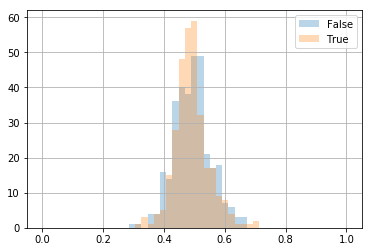

In [109]:
for idx, g in df.groupby("true"):
    g['pred'].hist(bins=np.linspace(0, 1, 50), label=idx, alpha=0.3)
    
plt.legend()